# PROYECTO DE FIN DE CURSO: Usando computación evolutiva para encontrar localizaciones optimas de una cadena de supermercados

## CURSO: Optimización Industrial con Computación Evolutiva.
## Integrantes:
1. Amao Suxo, Christian.
2. Piñas Rivera, Jose.
3. Sandoval Huaman, Dennis Edison.



Este proyecto consiste en usar los algoritmos monobjetivo y multiobjetivo aprendidos en el curso para encontrar localizaciones óptimas de una cadena de supermercados. Una conocida cadena de supermercados desea ingresar al mercado limeño. Usted, como experto en IA, ha sido contratado para proponer donde deben ser localizados los supermercados. Para ello, se le está proporcionando un mapa de la ciudad con 60 locales candidatos donde la cadena de supermercados podría localizar sus supermercados. Dicho mapa puede encontrarlo en: https://drive.google.com/open?id=1w7n77ByWK6TrX74lOBTwID719LRj_UQz&usp=sharing
La cadena tiene presupuesto para instalar 10 supermercados. Se le está proporcionando también una tabla con las coordenadas de las localizaciones candidatas y la población estimada que hay en 500 metros a la redonda (Candidatos_supermercados.xlsx).
Su objetivo es escoger los supermercados de manera que se maximice la suma de la población que vive a 500m alrededor de los supermercados y la suma de las distancias entre los supermercados escogidos. Existe la restricción de distancia mínima: cualquier par de supermercados escogidos no pueden estar ubicados a menos de 1Km de distancia en línea recta.

# I.- Planteamiento del algoritmo multi-objetivo

Trabajaremos el código ahora para definir un algoritmo multiobjetivo para resolver el mismo problema. Para ello consideraremos que:

*   La representación de los cromosomas seria la misma que el caso mono-objetivo
*  Los objetivos serían: a) suma de distancias entre todos los posibles pares de localizaciones escogidas en el individuo; y b) suma de las poblaciones alrededor de cada supermercado escogido en el individuo.

* Los operadores de cruzamiento, mutación pueden ser los mismos del caso mono-objetivo

* Experimente varias veces el algoritmo implementado con una población de 100 individuos y 500 generaciones (se sugiere
ejecutar 10 veces). En cada ejecución registre los individuos de la frontera de Pareto final, así como los valores de las funciones objetivos de dichos individuo. Realice plots de las fronteras de Pareto encontradas, ubicando en dichos plots los puntos de los mejores individuos encontrados con el algoritmo mono-objetivo.




In [146]:
# Procedemos a descargar las librerias necesarias:

import numpy as np
import pandas as pd
from random import sample, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt
from geopy.distance import geodesic


### Definimos la clase **Location**

Representa una localización candidata. Tiene tres atributos: latitud, longitud y población estimada en 500m.

In [151]:
# 1. Define el objeto Location para el problema

class Location:
    def __init__(self, lat, lon, population):
        self.lat = lat          # Latitud del local
        self.lon = lon          # Longitud del local
        self.population = population  # Población en 500m a la redonda


### Definimos la estructura de un individuo en el AG con sus operadores genéticos

In [152]:
# 2. Define la estructura de un individuo en el AG
class Individual:
    def __init__(self, chromosome):
        self.chromosome = chromosome[:]  # Vector binario (1=seleccionado, 0=no seleccionado)
        self.fitness = -1                # -1 indica no evaluado
        self.distance_matrix = None       # Cache para matriz de distancias

    def crossover_onepoint(self, other):
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]

    def crossover_uniform(self, other):
        chromosome1, chromosome2 = [], []
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        return [Individual(chromosome1), Individual(chromosome2)]

    def mutation_flip(self):
        new_chromosome = deepcopy(self.chromosome)
        mut_gene = randrange(0, len(new_chromosome))
        new_chromosome[mut_gene] = 1 if new_chromosome[mut_gene] == 0 else 0
        return Individual(new_chromosome)

### Definimos la función para obtener el fitness de un cromosoma:

In [153]:
# 3. Función de evaluación (fitness) multiobjetivo: Total Población y Suma de Distancias

def get_fitness(chromosome, locations):
    selected_indices = [i for i, val in enumerate(chromosome) if val == 1]
    num_selected = len(selected_indices)

    # Verificar restricción de exactamente 10 supermercados
    if num_selected != 10:
        return np.array([-1, -1])  # Solución inválida

    # Calcular distancias entre pares y verificar restricción de 1km
    total_distance = 0
    min_distance = float('inf')
    total_population = 0

    for i in range(num_selected):
        loc1 = locations[selected_indices[i]]
        total_population += loc1.population
        for j in range(i+1, num_selected):
            loc2 = locations[selected_indices[j]]
            distance = geodesic((loc1.lat, loc1.lon), (loc2.lat, loc2.lon)).km
            total_distance += distance
            if distance < min_distance:
                min_distance = distance

    # Verificar restricción de distancia mínima
    if min_distance < 1.0:
        return np.array([-1, -1])  # Solución inválida

    return np.array([total_distance, total_population])


### Definimos la función para evaluar la población de individuos

In [154]:
# Inicialización y evaluación de la población

# Inicialización y evaluación de la población
def init_population(pop_size, chromosome_size, num_selected=10, locations=None, min_dist_km=1.0):
    population = []

    while len(population) < pop_size:
        valid = False
        attempts = 0
        while not valid and attempts < 10000:
            attempts += 1
            # Seleccionar al azar un conjunto de índices
            candidate_indices = sample(range(chromosome_size), num_selected)
            valid = True
            # Verificar que todas las distancias sean >= min_dist_km
            for i in range(num_selected):
                for j in range(i+1, num_selected):
                    loc1 = locations[candidate_indices[i]]
                    loc2 = locations[candidate_indices[j]]
                    distance = geodesic((loc1.lat, loc1.lon), (loc2.lat, loc2.lon)).km
                    if distance < min_dist_km:
                        valid = False
                        break
                if not valid:
                    break

        # Si es válido, crear el individuo
        if valid:
            chromosome = [0] * chromosome_size
            for idx in candidate_indices:
                chromosome[idx] = 1
            population.append(Individual(chromosome))
        else:
            print("Advertencia: no se pudo generar un individuo válido después de 1000 intentos.")
            break

    return population

def evaluate_population(population, locations):
    for ind in population:
        if ind.fitness == -1:
            ind.fitness = get_fitness(ind.chromosome, locations)

### Definimos los operadores NSGA-II

In [155]:
def get_crowding_distances(fitnesses):
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])
    crowding_matrix = np.zeros((pop_size, num_objectives))

    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / np.ptp(fitnesses, axis=0)

    for col in range(num_objectives):
        crowding = np.zeros(pop_size)
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]
        crowding_matrix[:, col] = sorted_crowding

    return np.sum(crowding_matrix, axis=1)

In [156]:
def select_by_crowding(population, num_individuals):
    population = deepcopy(population)
    pop_size = len(population)
    num_objectives = len(population[0].fitness)

    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size):
        fitnesses[i,:] = population[i].fitness

    crowding_distances = get_crowding_distances(fitnesses)
    population_selected = []

    for _ in range(num_individuals):
        permut = np.random.permutation(len(population))
        ind1_id, ind2_id = permut[0], permut[1]

        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:
            population_selected.append(population.pop(ind1_id))
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
        else:
            population_selected.append(population.pop(ind2_id))
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return population_selected

In [157]:
def get_paretofront_population(population):
    population = deepcopy(population)
    pop_size = len(population)
    pareto_front = np.ones(pop_size, dtype=bool)

    for i in range(pop_size):
        for j in range(pop_size):
            if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and \
               any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                pareto_front[i] = 0
                break

    return [population[i] for i in range(pop_size) if pareto_front[i]]

In [158]:
def build_next_population(population, min_pop_size, max_pop_size):
    population = deepcopy(population)
    next_population = []

    while len(next_population) < min_pop_size:
        paretofront = get_paretofront_population(population)

        if len(next_population) + len(paretofront) > max_pop_size:
            paretofront = select_by_crowding(paretofront, max_pop_size - len(next_population))

        next_population.extend(paretofront)

        for ind in paretofront:
            for j in range(len(population)):
                if all(np.asarray(ind.chromosome) == np.asarray(population[j].chromosome)):
                    del population[j]
                    break

    return next_population

In [159]:
def build_offspring_population(population, crossover, mutation, pmut):
    pop_size = len(population)
    mating_pool = []

    for _ in range(int(pop_size/2)):
        permut = np.random.permutation(pop_size)
        mating_pool.append((population[permut[0]], population[permut[1]]))

    offspring = []
    for pair in mating_pool:
        if crossover == "onepoint":
            offspring.extend(pair[0].crossover_onepoint(pair[1]))
        elif crossover == "uniform":
            offspring.extend(pair[0].crossover_uniform(pair[1]))

    for i in range(len(offspring)):
        if uniform(0, 1) < pmut:
            if mutation == "flip":
                offspring[i] = offspring[i].mutation_flip()

    return offspring

### Probamos simulaciones del algoritmo:

In [160]:
# Cargar datos desde el archivo Excel
def load_locations(filepath):
    df = pd.read_excel(filepath)
    return [Location(row['Latitud'], row['Longitud'], row['Poblacion500m']) for _, row in df.iterrows()]

In [164]:
locations = load_locations('../02_DATOS/Candidatos_supermercados.xlsx')
NUM_LOCATIONS = len(locations)

# Parámetros del algoritmo
MIN_POP_SIZE = 100
MAX_POP_SIZE = 100
CHROMOSOME_SIZE = NUM_LOCATIONS
GENERATIONS = 500
PMUT = 0.5
NUM_RUNS = 10

all_pareto_fronts = []

for run in range(NUM_RUNS):
  print(f"\nEjecución {run+1} de {NUM_RUNS}")
  # Inicializar población
  population = init_population(MAX_POP_SIZE, CHROMOSOME_SIZE, num_selected=10, locations=locations)
  evaluate_population(population, locations)

  # Algoritmo NSGA-II
  for g in range(GENERATIONS):
    if g % 10 == 0:
      print(f'Generación {g} (de {GENERATIONS})')

    offspring = build_offspring_population(population, "uniform", "flip", PMUT)
    evaluate_population(offspring, locations)
    population.extend(offspring)
    population = build_next_population(population, MIN_POP_SIZE, MAX_POP_SIZE)

  # Obtener frente de Pareto
  pareto_front = get_paretofront_population(population)
  all_pareto_fronts.append(pareto_front)



Ejecución 1 de 10
Generación 0 (de 500)
Generación 10 (de 500)
Generación 20 (de 500)
Generación 30 (de 500)
Generación 40 (de 500)
Generación 50 (de 500)
Generación 60 (de 500)
Generación 70 (de 500)
Generación 80 (de 500)
Generación 90 (de 500)
Generación 100 (de 500)
Generación 110 (de 500)
Generación 120 (de 500)
Generación 130 (de 500)
Generación 140 (de 500)
Generación 150 (de 500)
Generación 160 (de 500)
Generación 170 (de 500)
Generación 180 (de 500)
Generación 190 (de 500)
Generación 200 (de 500)
Generación 210 (de 500)
Generación 220 (de 500)
Generación 230 (de 500)
Generación 240 (de 500)
Generación 250 (de 500)
Generación 260 (de 500)
Generación 270 (de 500)
Generación 280 (de 500)
Generación 290 (de 500)
Generación 300 (de 500)
Generación 310 (de 500)
Generación 320 (de 500)
Generación 330 (de 500)
Generación 340 (de 500)
Generación 350 (de 500)
Generación 360 (de 500)
Generación 370 (de 500)
Generación 380 (de 500)
Generación 390 (de 500)
Generación 400 (de 500)
Generaci

In [165]:
# Guardamos los resultados del algoritmo multiobjetivo:

import pickle
with open('all_pareto_fronts_optimizado.pkl', 'wb') as f:
    pickle.dump(all_pareto_fronts, f)


In [166]:
with open('all_pareto_fronts_optimizado.pkl', 'rb') as f:
    paretos_runs = pickle.load(f)

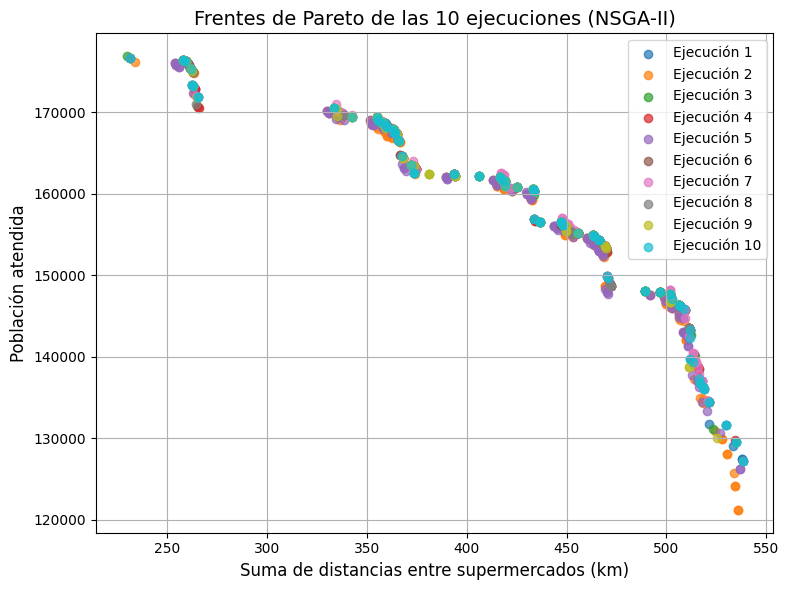

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for i, pareto_front in enumerate(paretos_runs):
    distances = [ind.fitness[0] for ind in pareto_front]
    populations = [ind.fitness[1] for ind in pareto_front]
    plt.scatter(distances, populations, label=f'Ejecución {i+1}', alpha=0.7)

plt.xlabel('Suma de distancias entre supermercados (km)', fontsize=12)
plt.ylabel('Población atendida', fontsize=12)
plt.title('Frentes de Pareto de las 10 ejecuciones (NSGA-II)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
mono_df = pd.read_excel('resultados_supermercados_mono_objetivo_v2.xlsx')
mono_df.head()

,run,fitness,total_pop,total_dist,locations
0,1,123898.964330,176900,229.881100,"[10, 14, 18, 21, 54, 15, 59, 1, 50, 22]"
1,2,124005.232641,177050,234.108805,"[15, 49, 10, 54, 19, 11, 59, 23, 14, 2]"
2,3,123689.578928,176600,231.929761,"[17, 14, 54, 59, 22, 19, 1, 15, 49, 16]"
3,4,123093.385237,175750,227.950789,"[49, 22, 2, 3, 19, 15, 14, 54, 59, 13]"
4,5,123689.554996,176600,231.849986,"[1, 15, 54, 14, 23, 50, 10, 59, 18, 21]"


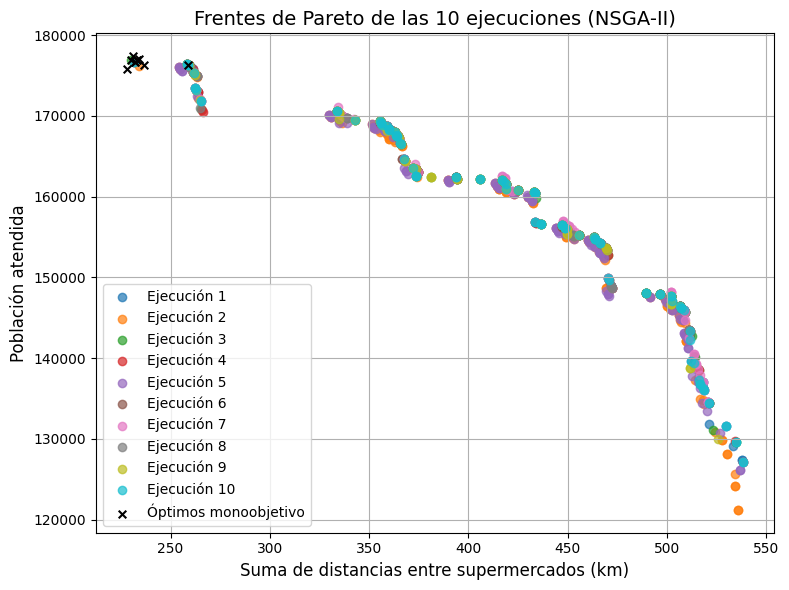

In [175]:
# Generamos el gráfico final considerando las soluciones óptimas halladas con el algoritmo monoobjetivo:

# Cargar archivo Excel con resultados monoobjetivo
mono_df = pd.read_excel('resultados_supermercados_mono_objetivo_v2.xlsx')

# Asumiendo que las columnas se llaman exactamente 'DistanciaTotal' y 'PoblacionTotal'
mono_distances = mono_df['total_dist']
mono_populations = mono_df['total_pop']

# Volver a graficar los frentes de Pareto
plt.figure(figsize=(8, 6))

for i, pareto_front in enumerate(paretos_runs):
    distances = [ind.fitness[0] for ind in pareto_front]
    populations = [ind.fitness[1] for ind in pareto_front]
    plt.scatter(distances, populations, label=f'Ejecución {i+1}', alpha=0.7)

# Agregar los puntos óptimos monoobjetivo con aspas
plt.scatter(mono_distances, mono_populations, color='black', marker='x', s=30, label='Óptimos monoobjetivo')

plt.xlabel('Suma de distancias entre supermercados (km)', fontsize=12)
plt.ylabel('Población atendida', fontsize=12)
plt.title('Frentes de Pareto de las 10 ejecuciones (NSGA-II)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CONCLUSIONES FINALES

*  Las soluciones dadas por el algoritmo monoobjetivo se concentran en las soluciones con mayor población atendida y menor suma de distancias entre supermercado. Esto ocurre por asignar un mayor peso en la función de fitness al objetivo de población atendida. Si se deseasen soluciones más diversas, se tendrían que modificar los pesos del fitness asignados a los dos objetivos.

* Las soluciones brindadas por el enfoque multiobjetivo (NSGA-II) mediante las fronteras de Pareto entregan varias alternativas de soluciones de alta calidad. La frontera de Pareto brinda diversas soluciones y estas se pueden adaptar mejor a decisiones prácticas, donde a veces no hay un único criterio absoluto.

*  Finalmente, concluímos que el uso de un enfoque multiobjetivo como NSGA-II resulta más adecuado para este problema, ya que proporciona un conjunto diverso de soluciones que permiten equilibrar de manera flexible la población atendida y la suma de distancias, facilitando una mejor toma de decisiones frente a las soluciones dada por los enfoques mono-objetivo.